In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH='data/dogscats/'
sz=299
arch=resnext50
bs=14

In [3]:
!ls {PATH}test1 | head

10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
ls: write error: Broken pipe


In [4]:
ImageClassifierData.from_paths

<bound method ImageClassifierData.from_paths of <class 'fastai.dataset.ImageClassifierData'>>

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4, test_name='test1')
learn = ConvLearner.pretrained(arch, data)
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 63%|██████▎   | 1041/1643 [06:51<03:57,  2.53it/s, loss=0.249]

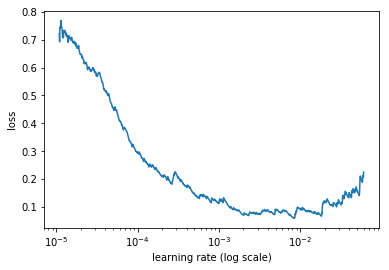

In [6]:
learn.sched.plot()

In [7]:
1e-4

0.0001

In [5]:
learn.fit(1e-4, 3, cycle_len=1)

A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



  0%|          | 1/1643 [00:01<29:43,  1.09s/it, loss=0.759]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.10366  0.0433   0.99151]                           
[ 1.       0.06854  0.0322   0.99251]                           
[ 2.       0.06381  0.03115  0.99242]                           



In [6]:
learn.save('299_resnext_pre_differential_lr')

In [4]:
# learn.load('299_resnext_pre_differential_lr')

In [5]:
learn.unfreeze()
learn.bn_freeze(True)
%time learn.fit([1e-5, 1e-4, 1e-3], 1, cycle_len=1)

A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/home/

[ 0.       0.01952  0.01241  0.9965 ]                            

CPU times: user 26min 29s, sys: 1min 25s, total: 27min 54s
Wall time: 16min 1s


In [6]:
# learn.save('299_resnext_post_differential_lr')

In [6]:
learn.load('299_resnext_post_differential_lr')

In [1]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [8]:
%time log_preds, y = learn.TTA(is_test=True)
# metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds, y)
probs = np.exp(log_preds)

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


CPU times: user 30min 32s, sys: 1min 25s, total: 31min 57s
Wall time: 13min 27s


In [9]:
preds = np.argmax(log_preds, axis=1)
# probs = np.exp(log_preds)

In [3]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

NameError: name 'preds' is not defined

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[6256 6244]
 [   0    0]]


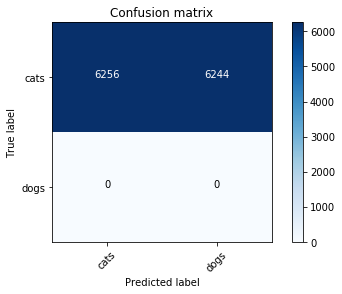

In [11]:
plot_confusion_matrix(cm, data.classes)

In [17]:
#2:05:20

In [15]:
data.test_ds.fnames

['test1/1.jpg',
 'test1/10.jpg',
 'test1/100.jpg',
 'test1/1000.jpg',
 'test1/10000.jpg',
 'test1/10001.jpg',
 'test1/10002.jpg',
 'test1/10003.jpg',
 'test1/10004.jpg',
 'test1/10005.jpg',
 'test1/10006.jpg',
 'test1/10007.jpg',
 'test1/10008.jpg',
 'test1/10009.jpg',
 'test1/1001.jpg',
 'test1/10010.jpg',
 'test1/10011.jpg',
 'test1/10012.jpg',
 'test1/10013.jpg',
 'test1/10014.jpg',
 'test1/10015.jpg',
 'test1/3207.jpg',
 'test1/3208.jpg',
 'test1/3209.jpg',
 'test1/321.jpg',
 'test1/3210.jpg',
 'test1/3211.jpg',
 'test1/3212.jpg',
 'test1/3213.jpg',
 'test1/3214.jpg',
 'test1/3215.jpg',
 'test1/3216.jpg',
 'test1/3217.jpg',
 'test1/3218.jpg',
 'test1/3219.jpg',
 'test1/322.jpg',
 'test1/3220.jpg',
 'test1/3221.jpg',
 'test1/3222.jpg',
 'test1/3223.jpg',
 'test1/3224.jpg',
 'test1/3225.jpg',
 'test1/3226.jpg',
 'test1/3227.jpg',
 'test1/3228.jpg',
 'test1/3229.jpg',
 'test1/323.jpg',
 'test1/3230.jpg',
 'test1/3231.jpg',
 'test1/3232.jpg',
 'test1/3233.jpg',
 'test1/3234.jpg',
 'tes

In [12]:
probs.shape

(12500, 2)

In [13]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [14]:
df.head()

,cats,dogs
0,0.000005,0.999994
1,0.999968,0.000026
2,0.999955,0.000042
3,0.000019,0.999977
4,0.000023,0.999965


In [16]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w'); 
    c.flush()

In [17]:
save_array('preds.bc', df)

In [ ]:
df.insert(0, 'id', [o[6:-4] for o in data.test_ds.fnames])

In [26]:
df.rename(columns={'dogs': 'label'})

,id,cats,label
0,1,0.000005,9.999942e-01
1,10,0.999968,2.576325e-05
2,100,0.999955,4.241739e-05
3,1000,0.000019,9.999774e-01
4,10000,0.000023,9.999647e-01
5,10001,0.999994,3.160788e-06
6,10002,0.999987,1.164707e-05
7,10003,0.000583,9.931668e-01
8,10004,0.006882,9.925356e-01
9,10005,0.999986,1.306518e-05


In [27]:
del df['cats']

In [28]:
df.head()

,id,dogs
0,1,0.999994
1,10,0.000026
2,100,0.000042
3,1000,0.999977
4,10000,0.999965


In [29]:
df = df.rename(columns={'dogs': 'label'})

In [30]:
df.head()

,id,label
0,1,0.999994
1,10,0.000026
2,100,0.000042
3,1000,0.999977
4,10000,0.999965


In [33]:
df.sort_values(by=['id'])

,id,label
0,1,9.999942e-01
1,10,2.576325e-05
2,100,4.241739e-05
3,1000,9.999774e-01
4,10000,9.999647e-01
5,10001,3.160788e-06
6,10002,1.164707e-05
7,10003,9.931668e-01
8,10004,9.925356e-01
9,10005,1.306518e-05


In [34]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [35]:
FileLink(f'{SUBM}subm.gz')

/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/data/dogscats/subm/subm.gz

In [36]:
save_array('preds_final.bc', df)

In [37]:
!ls


cifar10.ipynb		lesson1.ipynb		    nlp.ipynb
data			lesson1-rxt50-Copy1.ipynb   planet_cv.ipynb
excel			lesson1-rxt50-Copy2.ipynb   planet.py
fastai			lesson1-rxt50.ipynb	    preds.bc
fish.ipynb		lesson1-sgd.ipynb	    preds_final.bc
images			lesson1-vgg.ipynb	    __pycache__
keras_lesson1.ipynb	lesson2-image_models.ipynb  resnext50-dogscats.ipynb
lang_model-arxiv.ipynb	lesson3-rossman.ipynb	    rossman_exp.py
lang_model-imdb.ipynb	nasnet.ipynb		    scripts
lang_model.ipynb	nlp-arxiv.ipynb		    test_transforms.ipynb


In [38]:
!mv preds*.bc data/dogscats/

In [39]:
!ls


cifar10.ipynb		lesson1.ipynb		    nlp.ipynb
data			lesson1-rxt50-Copy1.ipynb   planet_cv.ipynb
excel			lesson1-rxt50-Copy2.ipynb   planet.py
fastai			lesson1-rxt50.ipynb	    __pycache__
fish.ipynb		lesson1-sgd.ipynb	    resnext50-dogscats.ipynb
images			lesson1-vgg.ipynb	    rossman_exp.py
keras_lesson1.ipynb	lesson2-image_models.ipynb  scripts
lang_model-arxiv.ipynb	lesson3-rossman.ipynb	    test_transforms.ipynb
lang_model-imdb.ipynb	nasnet.ipynb
lang_model.ipynb	nlp-arxiv.ipynb
